# Descriptions

In [1]:
# TODO(Grisha): this is a placeholder for the Master model qualifier notebook.
# The goal is to compare the prod system output when changing the system.config.

# TODO(Grisha): probably it belongs to `dataflow/system` or to `dataflow_amp/Cx/system`.
# TODO(Grisha): -> Master_system_config_qualifier?

# Imports

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import logging

import pandas as pd

import core.config as cconfig
import core.plotting as coplotti
import dataflow.core as dtfcore
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import reconciliation as reconcil

/app/amp/core/explore.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tauton


In [4]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-2115bae8-6120-4271-a352-ad9b7fb7a89c.json'
-----------------------------------------------------------------------------
This code is not in sync with the container:
code_version='1.4.2' != container_version='1.4.0'
-----------------------------------------------------------------------------
You need to:
- merge origin/master into your branch with `invoke git_merge_master`
- pull the latest container with `invoke docker_pull`
INFO  # Git
  branch_name='CmTask4285_add_config'
  hash='376e4c895'
  # Last commits:
    * 376e4c895 PomazkinG checkpoint                                                        ( 9 minutes ago) Wed Apr 26 14:58:41 2023  (HEAD -> CmTask4285_add_config)
    * 6ad969df9 Vlad     CmTask4098: rework daily download to iterative way (#4236)        (  20 hours ago) Tue Apr 25 19:33:42 2023  (origin/master, origin/HEAD, master)
    * ab15fd559 Grigorii Pomaz

# Config

In [5]:
config = {
    "bar_duration": "5T",
    "run_dag_comparison": True,
    "system_log_dir_path": {
        "prod": "/shared_data/style_experiment/system_log_dir_style_cross_sectional",
        "candidate": "/shared_data/style_experiment/system_log_dir_style_longitudinal",
    },
}
config = cconfig.Config().from_dict(config)
print(config)

bar_duration: 5T
run_dag_comparison: True
system_log_dir_path: 
  prod: /shared_data/style_experiment/system_log_dir_style_cross_sectional
  candidate: /shared_data/style_experiment/system_log_dir_style_longitudinal


# Specify the paths to DAG and Portfolio results

In [6]:
# This dict points to `system_log_dir/dag/node_io/node_io.data` for different experiments.
data_type = "dag_data"
dag_path_dict = reconcil.get_system_log_paths(
    config["system_log_dir_path"].to_dict(), data_type
)
dag_path_dict

{'prod': '/shared_data/style_experiment/system_log_dir_style_cross_sectional/dag/node_io/node_io.data',
 'candidate': '/shared_data/style_experiment/system_log_dir_style_longitudinal/dag/node_io/node_io.data'}

In [7]:
# This dict points to `system_log_dir/process_forecasts/portfolio` for different experiments.
data_type = "portfolio"
portfolio_path_dict = reconcil.get_system_log_paths(
    config["system_log_dir_path"].to_dict(), data_type
)
portfolio_path_dict

{'prod': '/shared_data/style_experiment/system_log_dir_style_cross_sectional/process_forecasts/portfolio',
 'candidate': '/shared_data/style_experiment/system_log_dir_style_longitudinal/process_forecasts/portfolio'}

# Compare DAG output

In [8]:
if config["run_dag_comparison"]:
    # TODO(Grisha): consider comparing the output for all bars / nodes.
    # The last node, the last timestamp.
    node_name = "predict.5.process_forecasts"
    # TODO(Grisha): get the last bar programatically.
    bar_timestamp = pd.Timestamp(
        "2023-04-18 14:00:00-0400", tz="America/New_York"
    )
    # Load the data.
    dag_prod_df = dtfcore.get_dag_node_output(
        dag_path_dict["prod"], node_name, bar_timestamp
    )
    hpandas.df_to_str(dag_prod_df, num_rows=5, log_level=logging.INFO)
    #
    dag_candidate_df = dtfcore.get_dag_node_output(
        dag_path_dict["candidate"], node_name, bar_timestamp
    )
    hpandas.df_to_str(dag_candidate_df, num_rows=3, log_level=logging.INFO)
    # TODO(Grisha): move kwargs to a config layer.
    compare_dfs_kwargs = {
        "diff_mode": "pct_change",
        "assert_diff_threshold": None,
    }
    diff_df = hpandas.compare_dfs(
        dag_prod_df, dag_candidate_df, **compare_dfs_kwargs
    )
    max_diff = diff_df.abs().max().max()
    _LOG.info(
        "The maximum absolute difference between the DAG ouputs is: %s", max_diff
    )
else:
    # Sometimes it is ok that the DAG results do not match.
    _LOG.info("Skpping the DAG comparison stage as per request")

feature                                                                                                                                                                                                                                                                          close_vol                                                                                                                                                                                                                                                                         garman_klass_vol                                                                                                                                                                                                                                                                         parkinson_vol                                                                                                                                                                                                                                                                              close                                                                                                                                                                                                                                                                                cmf                                                                                                                                                                                                                                                                               high                                                                                                                                                                                                                                                                                low                                                                                                                                                                                                                                                                               open                                                                                                                                                                                                                                                                               twap                                                                                                                                                                                                                                                                             volume                                                                                                                                                                                                                                                                                 vwap                                                                                                                                                                                                                                                                              
                          1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573       1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 23848

feature                                                                                                                                                                                                                                                                          close_vol                                                                                                                                                                                                                                                                         garman_klass_vol                                                                                                                                                                                                                                                                         parkinson_vol                                                                                                                                                                                                                                                                              close                                                                                                                                                                                                                                                                                cmf                                                                                                                                                                                                                                                                               high                                                                                                                                                                                                                                                                                low                                                                                                                                                                                                                                                                               open                                                                                                                                                                                                                                                                               twap                                                                                                                                                                                                                                                                             volume                                                                                                                                                                                                                                                                                 vwap                                                                                                                                                                                                                                                                              
                          1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573       1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 23848

INFO  The maximum absolute difference between the DAG ouputs is: 0.0


# Compare DAG execution time

In [9]:
# TODO(Grisha): create a plotting function that compares the results back-to-back instead
# of visually comparing 2 plots.

The DAG execution time almost did not change.

In [10]:
df_dag_execution_time_prod = dtfcore.get_execution_time_for_all_dag_nodes(
    dag_path_dict["prod"]
)
_LOG.info("DAG execution time:")
hpandas.df_to_str(df_dag_execution_time_prod, num_rows=3, log_level=logging.INFO)

INFO  DAG execution time:


,all_nodes,read_data,compute_bar_feature,resample,compute_vol,generate_feature,process_forecasts
2023-04-18 10:00:00-04:00,24.454,6.647,7.694,2.645,2.502,2.49,2.476
,...,...,...,...,...,...,...
2023-04-18 14:00:00-04:00,25.567,6.762,8.089,2.804,2.684,2.643,2.585


In [11]:
df_dag_execution_time_candidate = dtfcore.get_execution_time_for_all_dag_nodes(
    dag_path_dict["candidate"]
)
_LOG.info("DAG execution time:")
hpandas.df_to_str(
    df_dag_execution_time_candidate, num_rows=3, log_level=logging.INFO
)

INFO  DAG execution time:


,all_nodes,read_data,compute_bar_feature,resample,compute_vol,generate_feature,process_forecasts
2023-04-18 10:00:00-04:00,26.101,6.885,8.379,2.855,2.703,2.72,2.559
,...,...,...,...,...,...,...
2023-04-18 14:00:00-04:00,26.47,7.009,8.253,2.965,2.799,2.737,2.707


,mean,min,max,std
all_nodes,25.246776,24.454,27.998,0.721003
read_data,6.805673,6.647,7.814,0.205902
compute_bar_feature,7.920184,7.694,8.869,0.266642
resample,2.769429,2.645,3.302,0.112812
compute_vol,2.616571,2.502,3.206,0.114543
generate_feature,2.579102,2.485,2.952,0.085409
process_forecasts,2.555816,2.446,2.894,0.075686


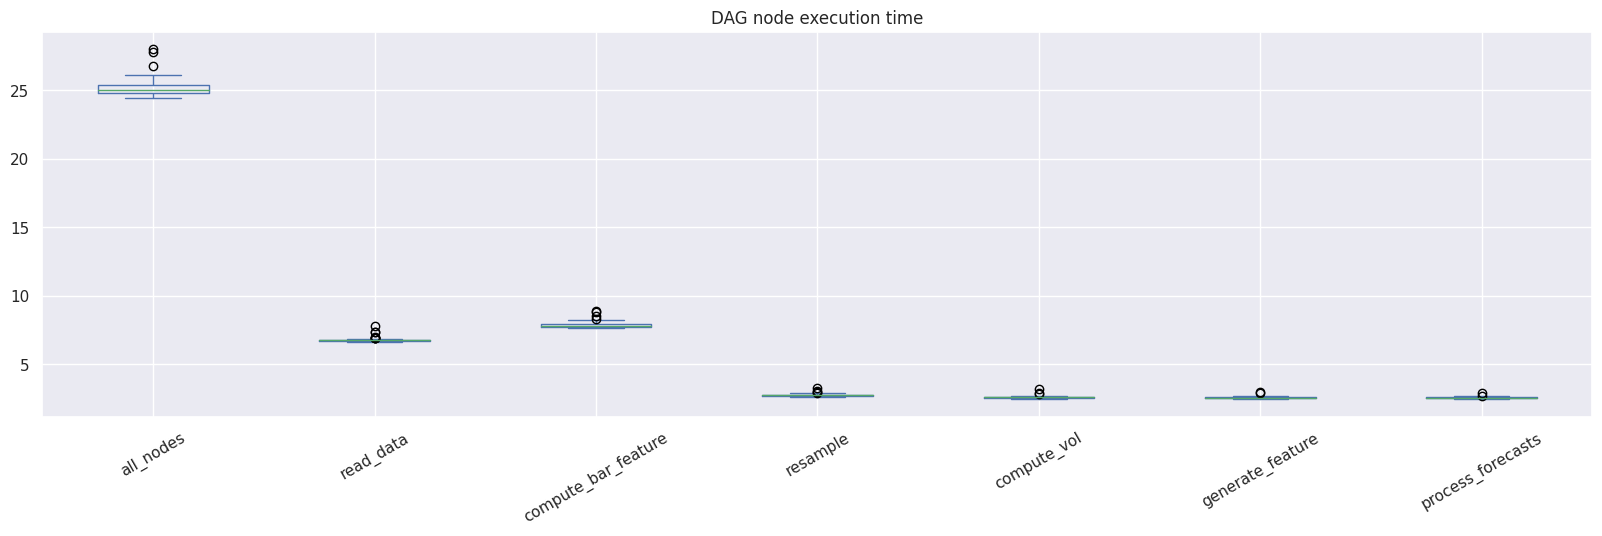

In [12]:
dtfcore.plot_dag_execution_stats(df_dag_execution_time_prod, report_stats=True)

,mean,min,max,std
all_nodes,27.939592,24.607,73.562,8.985331
read_data,8.465959,6.642,53.883,8.174059
compute_bar_feature,8.011980,7.727,8.901,0.246178
resample,2.865653,2.673,3.639,0.155814
compute_vol,2.683837,2.540,3.047,0.098367
generate_feature,3.140510,2.515,26.896,3.465945
process_forecasts,2.771653,2.463,9.964,1.054160


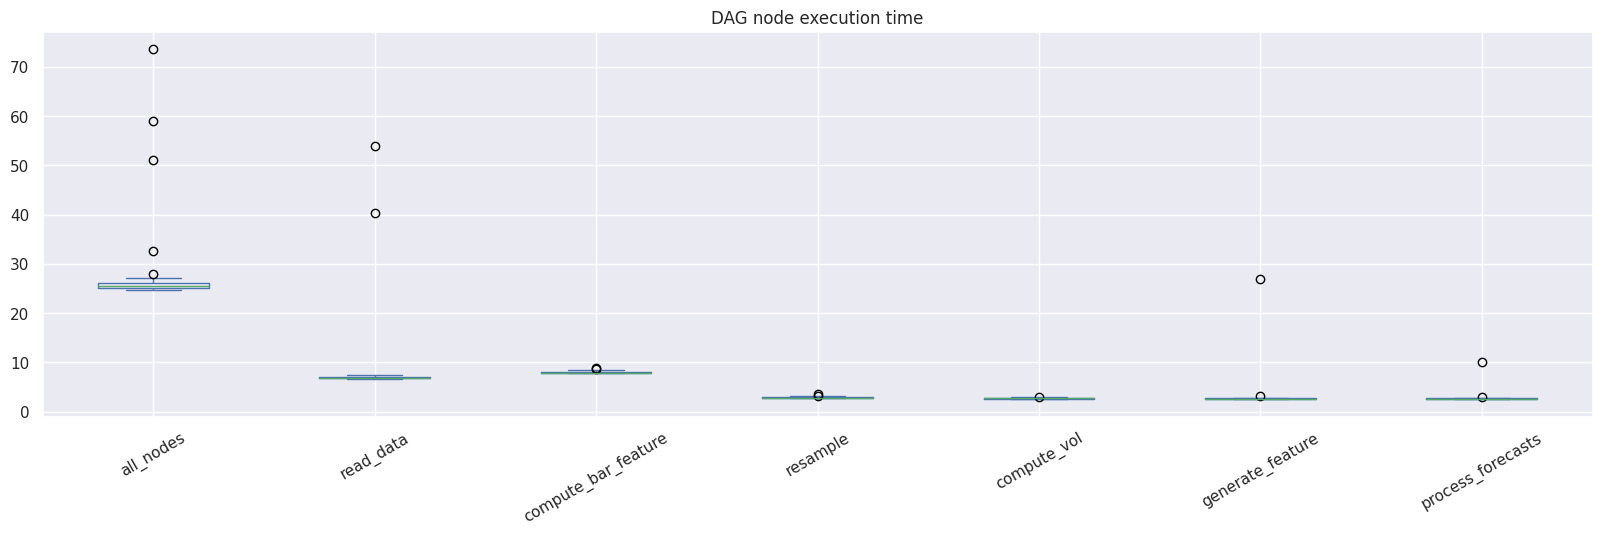

In [13]:
dtfcore.plot_dag_execution_stats(
    df_dag_execution_time_candidate, report_stats=True
)

# Compare DAG memory consumption

In [14]:
# TODO(Grisha): create a plotting function that compares the results back-to-back instead
# of visually comparing 2 plots.

In [15]:
dag_df_out_size_prod = dtfcore.get_dag_df_out_size_for_all_nodes(
    dag_path_dict["prod"]
)
_LOG.info("DAG results df size:")
hpandas.df_to_str(dag_df_out_size_prod, num_rows=5, log_level=logging.INFO)

INFO  DAG results df size:


read_data        compute_bar_feature        resample        compute_vol        generate_feature        process_forecasts       
                             n_cols n_rows              n_cols n_rows   n_cols n_rows      n_cols n_rows           n_cols n_rows            n_cols n_rows
2023-04-18 10:00:00-04:00       275   5760                 300   5760      200   1152         275   1152              300   1152               300   1152
2023-04-18 10:05:00-04:00       275   5760                 300   5760      200   1152         275   1152              300   1152               300   1152
                                ...    ...                 ...    ...      ...    ...         ...    ...              ...    ...               ...    ...
2023-04-18 13:55:00-04:00       275   5760                 300   5760      200   1152         275   1152              300   1152               300   1152
2023-04-18 14:00:00-04:00       275   5760                 300   5760      200   1152         275   1152              300   1152               300   1152

In [16]:
dag_df_out_size_candidate = dtfcore.get_dag_df_out_size_for_all_nodes(
    dag_path_dict["candidate"]
)
_LOG.info("DAG results df size:")
hpandas.df_to_str(dag_df_out_size_candidate, num_rows=5, log_level=logging.INFO)

INFO  DAG results df size:


read_data        compute_bar_feature        resample        compute_vol        generate_feature        process_forecasts       
                             n_cols n_rows              n_cols n_rows   n_cols n_rows      n_cols n_rows           n_cols n_rows            n_cols n_rows
2023-04-18 10:00:00-04:00       275   5760                 300   5760      200   1152         275   1152              300   1152               300   1152
2023-04-18 10:05:00-04:00       275   5760                 300   5760      200   1152         275   1152              300   1152               300   1152
                                ...    ...                 ...    ...      ...    ...         ...    ...              ...    ...               ...    ...
2023-04-18 13:55:00-04:00       275   5760                 300   5760      200   1152         275   1152              300   1152               300   1152
2023-04-18 14:00:00-04:00       275   5760                 300   5760      200   1152         275   1152              300   1152               300   1152

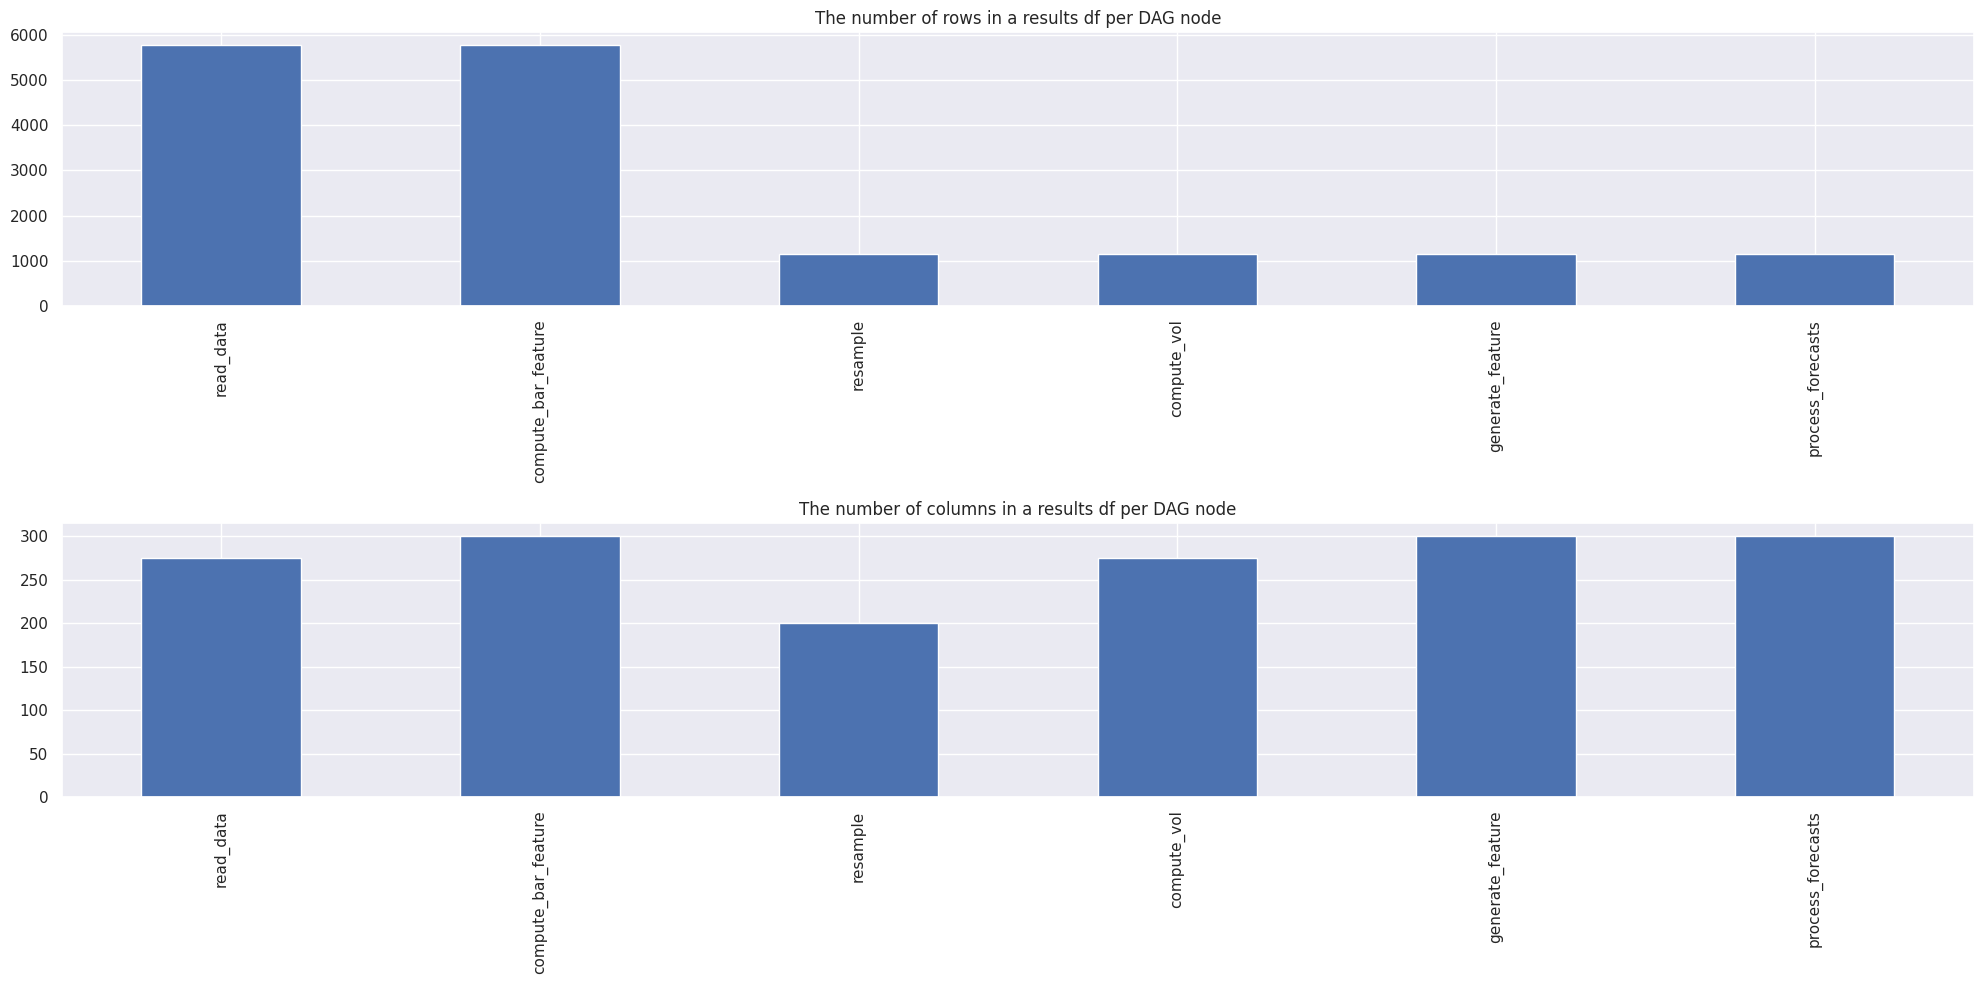

In [17]:
# Display the results df size distribution over the DAG nodes.
dtfcore.plot_dag_df_out_size_stats(dag_df_out_size_prod, report_stats=False)

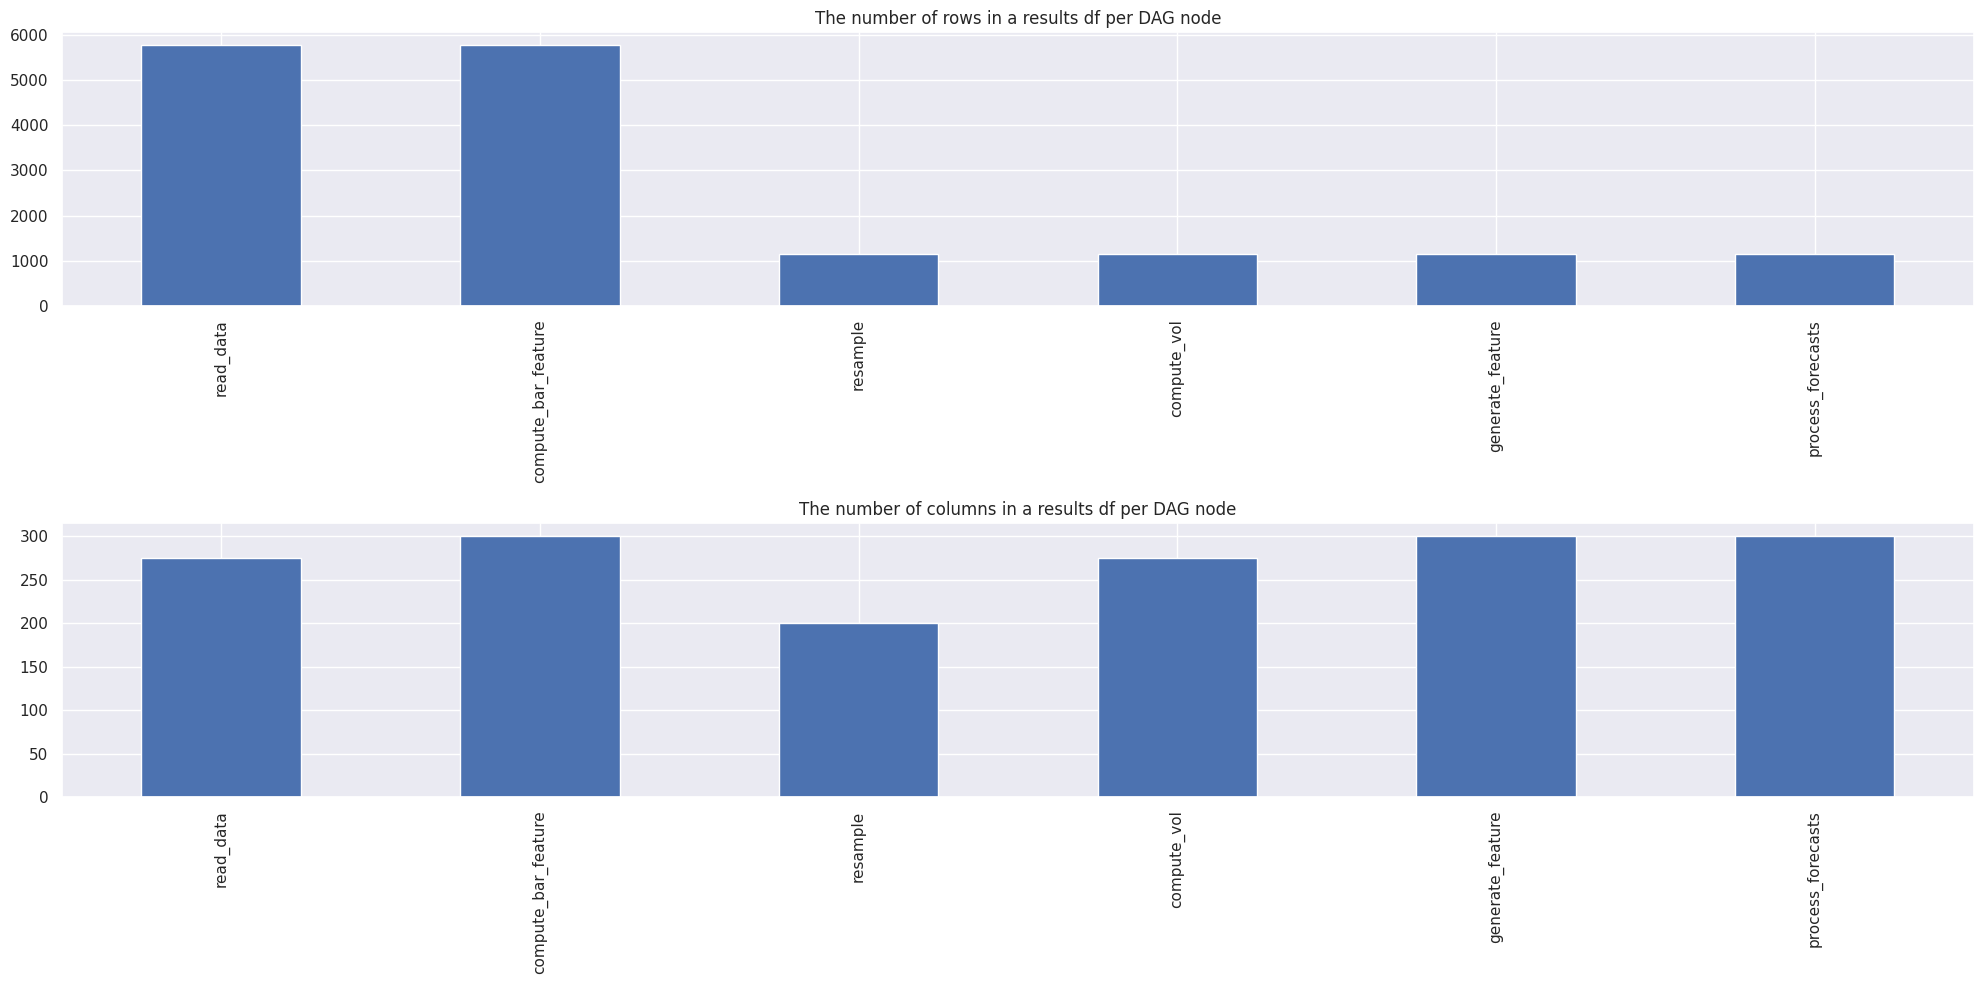

In [18]:
# Display the results df size distribution over the DAG nodes.
dtfcore.plot_dag_df_out_size_stats(dag_df_out_size_candidate, report_stats=False)

# Compare PnL

In [19]:
portfolio_dfs, portfolio_stats_dfs = reconcil.load_portfolio_dfs(
    portfolio_path_dict,
    config["bar_duration"],
)
hpandas.df_to_str(portfolio_dfs["prod"], num_rows=5, log_level=logging.INFO)

INFO  Processing portfolio=prod path=/shared_data/style_experiment/system_log_dir_style_cross_sectional/process_forecasts/portfolio


Loading `holdings_shares` files...:   0%|          | 0/49 [00:00<?, ?it/s]

Loading `holdings_notional` files...:   0%|          | 0/49 [00:00<?, ?it/s]

Loading `executed_trades_shares` files...:   0%|          | 0/49 [00:00<?, ?it/s]

Loading `executed_trades_notional` files...:   0%|          | 0/49 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/49 [00:00<?, ?it/s]

INFO  Processing portfolio=candidate path=/shared_data/style_experiment/system_log_dir_style_longitudinal/process_forecasts/portfolio


Loading `holdings_shares` files...:   0%|          | 0/49 [00:00<?, ?it/s]

Loading `holdings_notional` files...:   0%|          | 0/49 [00:00<?, ?it/s]

Loading `executed_trades_shares` files...:   0%|          | 0/49 [00:00<?, ?it/s]

Loading `executed_trades_notional` files...:   0%|          | 0/49 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/49 [00:00<?, ?it/s]

holdings_shares                                                                                                                                                                                                                                                                         holdings_notional                                                                                                                                                                                                                                                                           executed_trades_shares                                                                                                                                                                                                                                                                         executed_trades_notional                                                                                                                                                                                                                                                                                   pnl                                                                                                                                                                                                                                                                        
                               6051632686 8717633868 2540896331 1528092593 8968126878 1467591036 2476706208 5115052901 3065029174 1891737434 3401245610 1464553467 1966583502 1030828978 2601760471 2683705052 9872743573 2484635488 2099673105 4516629366 2237530510 2425308589 1776791608 2384892553 5118394986        1030828978  1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901  5118394986 6051632686 8717633868 8968126878 9872743573             6051632686 8717633868 2540896331 1528092593 8968126878 1467591036 2476706208 5115052901 3065029174 1891737434 3401245610 1464553467 1966583502 1030828978 2601760471 2683705052 9872743573 2484635488 2099673105 4516629366 2237530510 2425308589 1776791608 2384892553 5118394986               6051632686 8717633868 2540896331 1528092593  8968126878 1467591036 2476706208 5115052901 3065029174 1891737434  1464553467 1966583502 1030828978 2601760471 2683705052 9872743573 2484635488 2099673105 4516629366 2237530510 2425308589 2384892553  5118394986 3401245610 1776791608 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573
2023-04-18 10:00:00-04:00             0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0               0.0         0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0         0.0        0.0        0.0        0.0        0.0                    0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0                      NaN        NaN        NaN        NaN         NaN        NaN        NaN        NaN        NaN        NaN         NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN    

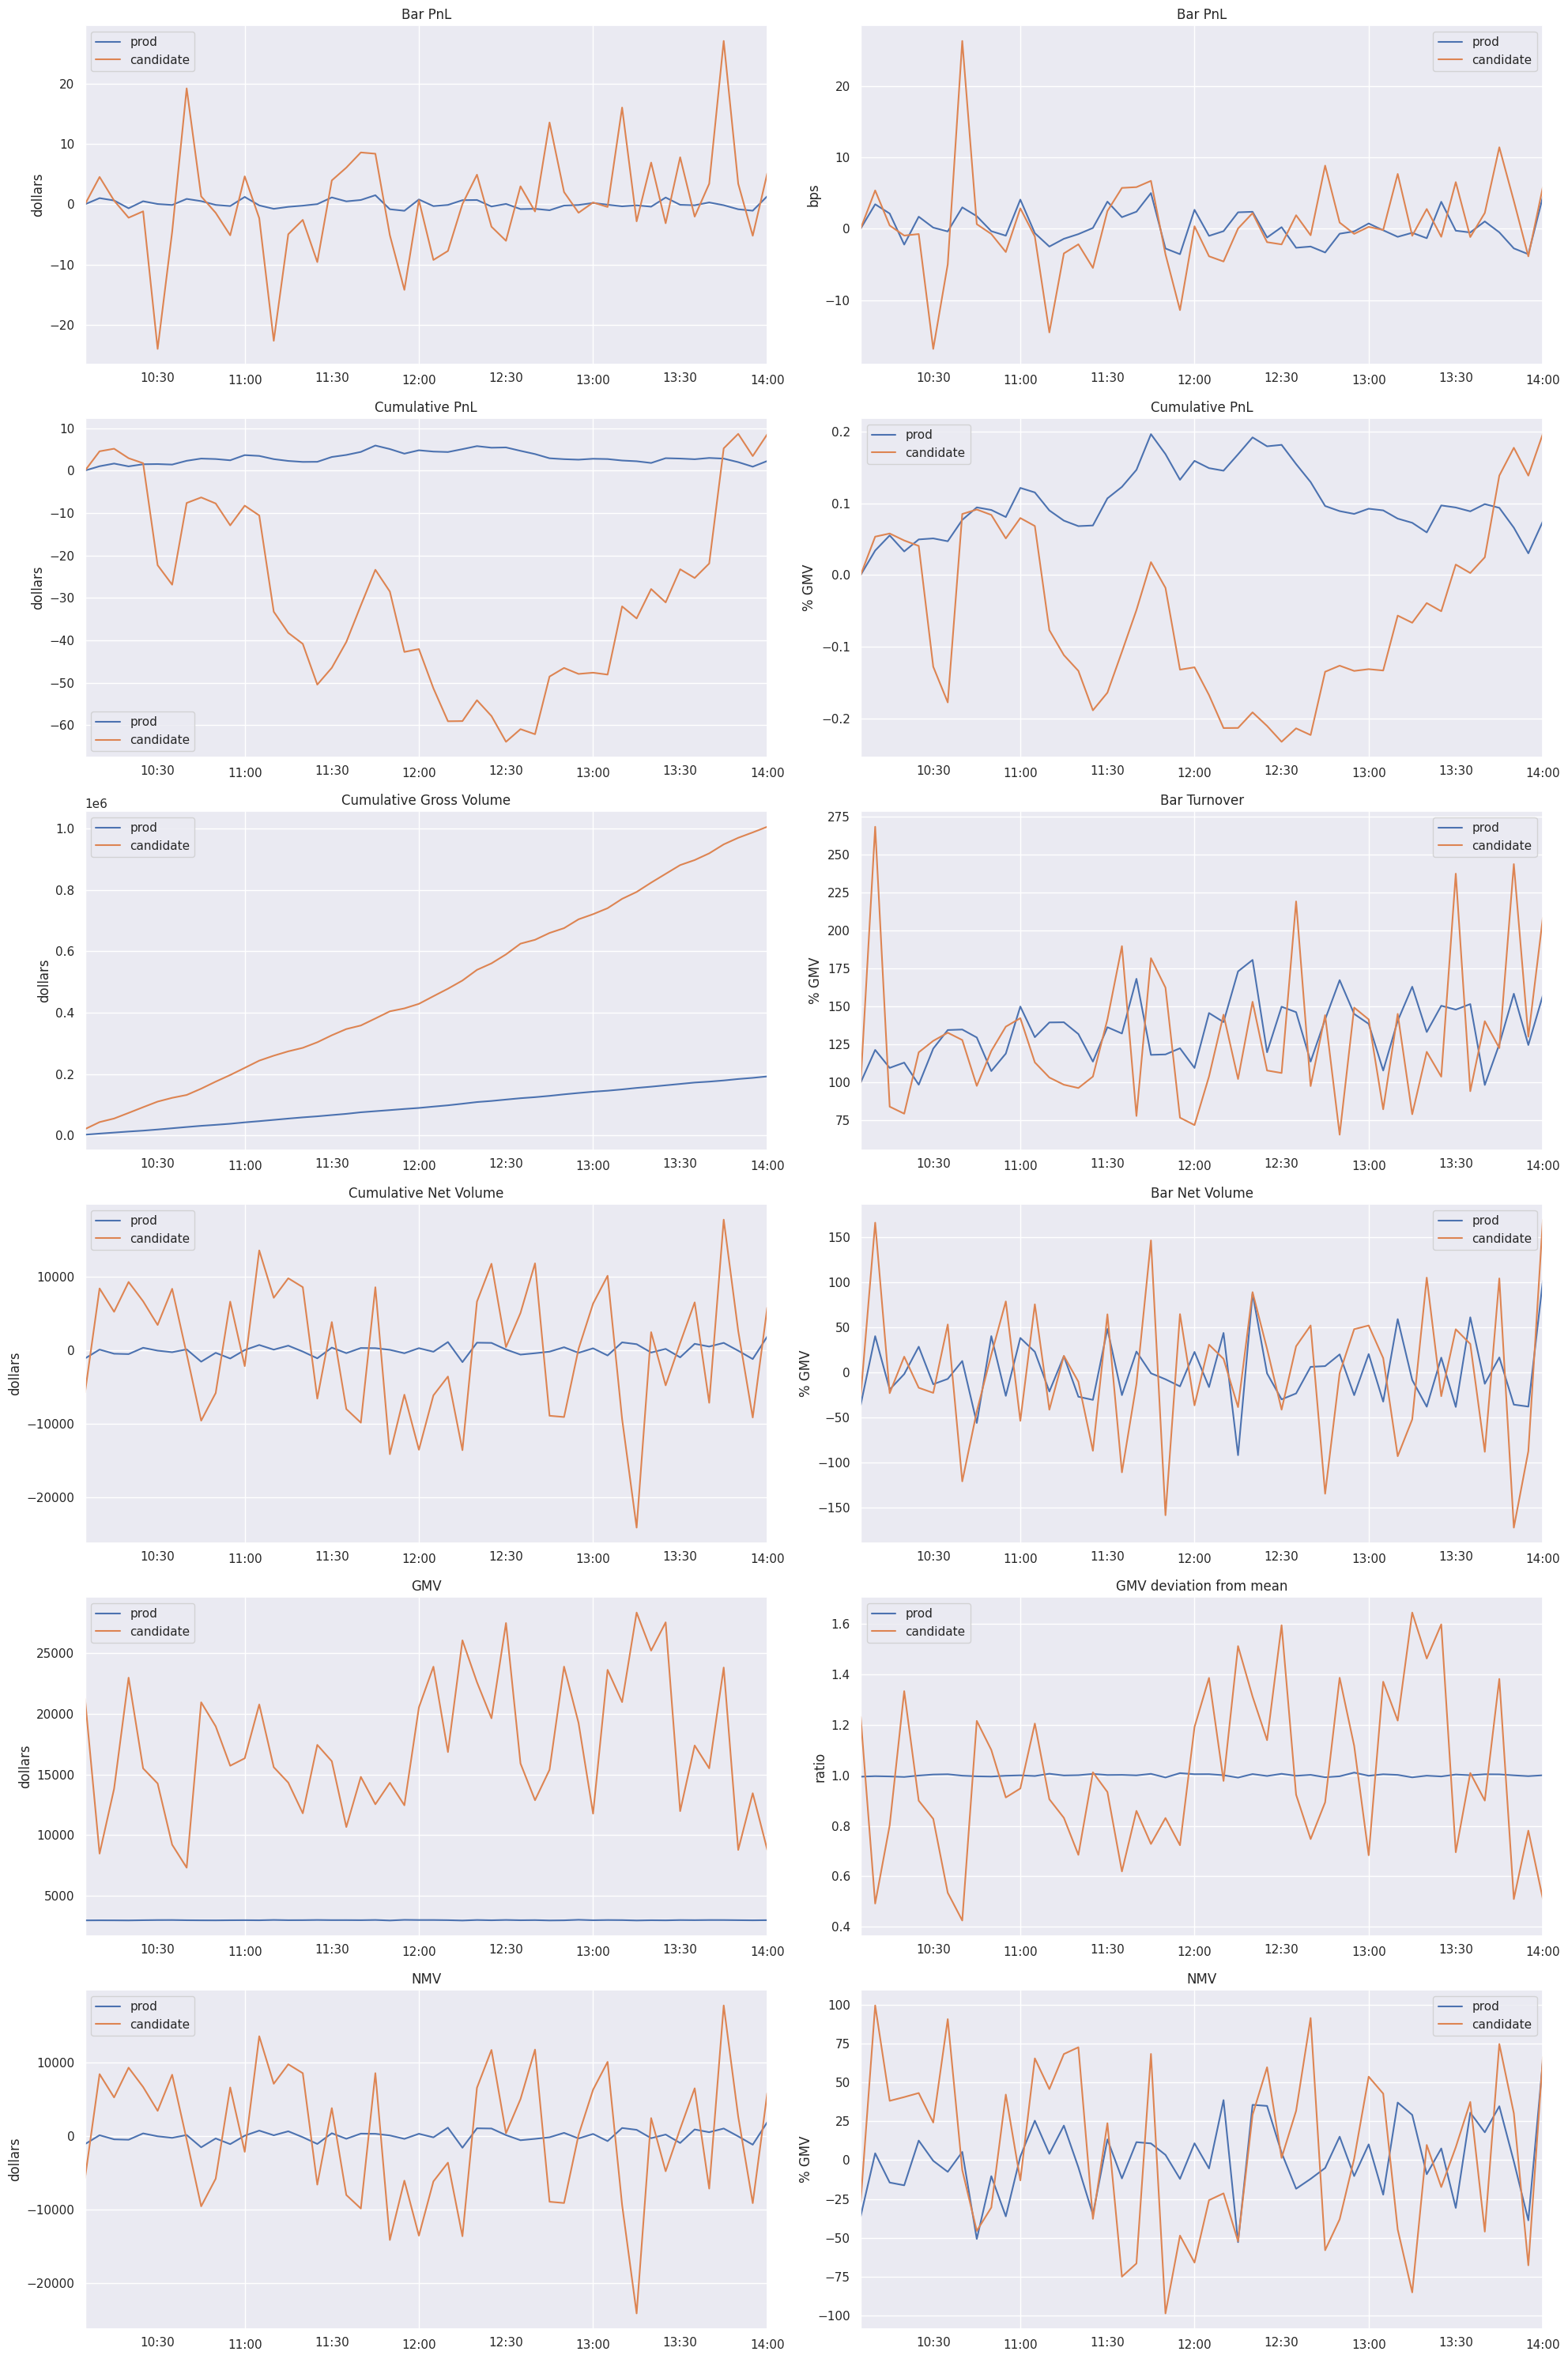

In [20]:
portfolio_stats_df = pd.concat(portfolio_stats_dfs, axis=1)
bars_to_burn = 1
coplotti.plot_portfolio_stats(portfolio_stats_df.iloc[bars_to_burn:])